# **Analysis of Twitch Social Network**

## **Introduction**

This project focuses on analyzing the social network of Twitch using the dataset provided by SNAP (Stanford Network Analysis Project). Twitch is a live-streaming platform, primarily for gaming, hosting a vast community of streamers and viewers. The Twitch social network is represented as an undirected graph, where nodes are users, and edges represent mutual friendships. This project aims to study the interaction dynamics, community structures, and user behaviors within the network.

---

## **Project Objectives**

### 1. **User Behavior Analysis**
I will examine the interactions between users on the platform by analyzing metrics such as:
- Node degree (number of connections).
- Centrality (relative importance of a node in the network).
- Distribution of connections and identification of influential users.

### 2. **Community Detection**
I will apply community detection algorithms to identify groups of users that are strongly connected. This will help to understand how communities form based on shared characteristics, such as language, preferred games, or geographical location.

### 3. **Explicit Content Analysis**
I will predict the likelihood of a streamer using explicit language based on their connections and attributes. This will be achieved using supervised machine learning techniques, leveraging node attributes and graph connections.

---

## **Methodology**

The project will be developed following these steps:
1. **Data Loading and Preprocessing**: Importing the edge list and node features, building the graph, and cleaning the data.
2. **Exploratory Network Analysis**: Studying the main characteristics of the network, such as the number of nodes, edges, and basic metrics.
3. **Experiments**:
   - User behavior analysis.
   - Community detection using clustering algorithms.
   - Explicit content prediction through classification.
4. **Evaluation**: Evaluating results and visualizing the network and analyses.

---

## **Tools Used**
- **Python**: The primary programming language.
- **NetworkX**: For graph manipulation and analysis.
- **Scikit-learn**: For implementing machine learning models.
- **Matplotlib/Seaborn**: For data and result visualization.
- **Gephi**: For interactive network visualization.


---



## **1. Data Loading and Preprocessing**


In [21]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import numpy as np


### 1. Load the dataset, including:
   - Edge list: representing user connections on Twitch.
   - Node features: describing user attributes (e.g., language, streaming behavior).

In [4]:
# Load the edge list
edgelist = pd.read_csv('large_twitch_edges.csv', )
# Display the first few rows to understand the structure
edgelist.head()

,numeric_id_1,numeric_id_2
0,98343,141493
1,98343,58736
2,98343,140703
3,98343,151401
4,98343,157118


In [5]:
# Load CSV file with node features
node_features = pd.read_csv("large_twitch_features.csv", index_col=5)
# Display the first few rows to understand the structure
node_features.head()

,views,mature,life_time,created_at,updated_at,dead_account,language,affiliate
numeric_id,,,,,,,,
0,7879,1,969,2016-02-16,2018-10-12,0,EN,1
1,500,0,2699,2011-05-19,2018-10-08,0,EN,0
2,382502,1,3149,2010-02-27,2018-10-12,0,EN,1
3,386,0,1344,2015-01-26,2018-10-01,0,EN,0
4,2486,0,1784,2013-11-22,2018-10-11,0,EN,0


At first sight, I note that:
- **Edge List**: Represents the connections between Twitch users, where each row is a link between two users (`numeric_id_1` and `numeric_id_2`).
- **Node Features**: Contains attributes for each user (node) such as:
  - `views`: Total number of views a streamer has.
  - `mature`: Indicates if the streamer produces mature content (1 for yes, 0 for no).
  - `life_time`: Lifetime of the user's account (in days).
  - `created_at` and `updated_at`: Account creation and last update dates.
  - `dead_account`: Indicates if the account is inactive.
  - `language`: The main language used by the user.
  - `affiliate`: Indicates if the user is a Twitch affiliate (1 for yes, 0 for no).

### 2. Clean and preprocess the data:
   - Handle missing values and duplicates.

In [6]:
# Check for null values and duplicates in the edge list
print("### Edge List ###")
print(f"Total rows in edge list: {edgelist.shape[0]}")

# Check for null values
null_values_edges = edgelist.isnull().sum()
print("Null values in edge list:")
print(null_values_edges)

# Check for duplicates
duplicates_edges = edgelist.duplicated().sum()
print(f"Duplicate rows in edge list: {duplicates_edges}")

print("\n")

# Check for null values and duplicates in the node attributes
print("### Node Attributes ###")
print(f"Total rows in node attributes: {node_features.shape[0]}")

# Check for null values
null_values_nodes = node_features.isnull().sum()
print("Null values in node attributes:")
print(null_values_nodes)

### Edge List ###
Total rows in edge list: 6797557
Null values in edge list:
numeric_id_1    0
numeric_id_2    0
dtype: int64
Duplicate rows in edge list: 0


### Node Attributes ###
Total rows in node attributes: 168114
Null values in node attributes:
views           0
mature          0
life_time       0
created_at      0
updated_at      0
dead_account    0
language        0
affiliate       0
dtype: int64


- **Edge List**:
  - No null values found in `numeric_id_1` or `numeric_id_2`.
  - No duplicate rows detected.

- **Node Attributes**:
  - No null values in any columns (`views`, `mature`, `life_time`, etc.).
  - No duplicate rows detected.

Both datasets are clean and ready for the next step: building the graph using the edge list and enriching it with node attributes.

### 3. Build the graph:
   - Use NetworkX to create the graph from the edge list.
   - Add node features to the graph.

In [7]:
OG = nx.from_pandas_edgelist(edgelist, source='numeric_id_1', target='numeric_id_2', create_using=nx.Graph())
print(OG)
print('Is the graph directed ?',OG.is_directed())

Graph with 168114 nodes and 6797557 edges
Is the graph directed ? False


I built an **undirected graph** where:
* Nodes are Twitch streamers.
* Edges are mutual friendships between Twitch streamers.


In [8]:
# Add node features to the graph
nx.set_node_attributes(OG, node_features.to_dict(orient='index'))

# Check correctness of this operation
example_node = list(OG.nodes)[0]
print(f"Attributes for node {example_node}: {OG.nodes[example_node]}")

Attributes for node 98343: {'views': 282, 'mature': 0, 'life_time': 2086, 'created_at': '2012-12-27', 'updated_at': '2018-09-13', 'dead_account': 0, 'language': 'EN', 'affiliate': 0}


Another important step is to check for **self loops** and removing them:

In [9]:
OG.remove_edges_from(nx.selfloop_edges(OG))
print(OG)

Graph with 168114 nodes and 6797557 edges


As we can see from the output, no edges have been removed.


For the purposes of this project and to facilitate analysis, I will take into account only a part of the network of Twitch streamers.
At first, I filter the nodes with `language` attribute and count them :


In [10]:
language_counts = defaultdict(int)

# Iteration through nodes
for node, attr in OG.nodes(data=True):
    language = attr.get('language', 'Unknown')
    language_counts[language] += 1

# Print 
for language, count in language_counts.items():
    print(f"Language: {language}, Count: {count}")

Language: EN, Count: 124411
Language: OTHER, Count: 1429
Language: ZH, Count: 2828
Language: ES, Count: 5699
Language: SV, Count: 854
Language: DE, Count: 9428
Language: RU, Count: 4821
Language: CS, Count: 576
Language: DA, Count: 503
Language: KO, Count: 1215
Language: IT, Count: 1230
Language: NL, Count: 701
Language: PT, Count: 2536
Language: NO, Count: 330
Language: FI, Count: 652
Language: FR, Count: 6799
Language: TR, Count: 772
Language: JA, Count: 1327
Language: HU, Count: 427
Language: TH, Count: 632
Language: PL, Count: 944


**French** network has a medium size, so I will use it as starting point, creating an independent subgraph (`G`) from the original one (`OG`)

In [11]:
# Filter nodes with attribute 'language' = 'FR'
nodes_with_fr = [n for n, attr in OG.nodes(data=True) if attr.get('language') == 'FR']

# Create independent subgraph
G = OG.subgraph(nodes_with_fr).copy()

print(G)
print(f'Is the graph directed?', G.is_directed())

Graph with 6799 nodes and 123644 edges
Is the graph directed? False


In [12]:
example_node = list(G.nodes)[0]
print(f"Attributes for node {example_node}: {G.nodes[example_node]}")

Attributes for node 32768: {'views': 1183, 'mature': 1, 'life_time': 280, 'created_at': '2018-01-04', 'updated_at': '2018-10-11', 'dead_account': 0, 'language': 'FR', 'affiliate': 1}


### 4. Save the cleaned data for later use.

In this section, I will save the Graph in a format compatible with Gephi, for visualisation.

In [84]:
nx.write_graphml(G, "twitch_networkFR.graphml")

### 5. Network Visualisation


The visualisation below is elaborated with Gephi. 

I used ForceAtlas2 and coloured nodes with green (affiliated streamers) and red (not affiliated streamers). 


![vis1](vis1.png)

This ForceAtlas2 visualization of the network reveals some key features of the graph:

1. **Clustering**:
    
   There is a **central cluster** that contains nodes that are highly connected, likely representing influential or well-integrated streamers within the network. The **peripheral nodes** are less connected and likely represent either new streamers or those with minimal interaction in the network. We can see that the majority of peripheral nodes are not affiliated streamers, meaning that nodes that are less connected / important aren't in collaboration with the Platform.

2. **Community Detection**:

   An important point to explore is if there are distinct communities within the network, and how affiliation and other attributes correlate with these groups. At first sight, we can see a big central cluster, but maybe this can be divided in more communities, maybe based on type of content or seniority.

3. **Role of Peripheral Nodes**:

   What characterizes the streamers in the periphery? Are they newcomers, or do they belong to smaller, isolated clusters?


---

## **2. USER BEHAVIOR ANALYSIS**


This section focuses on a deeper understanding of network features, in particular on how users are connected and interact.

At first, I will compute density:

In [13]:
density = nx.density(G)
print(f"Density of gragh: {density}")

Density of gragh: 0.005350284063458616


The Twitch French network has a density of **0.00535**, indicating that only the 0.5% of all possible connections are available. 

The network is **sparse**. This is typical for large social networks, where users selectively connect to a small subset of others with similar interests rather than forming a densely connected graph.

????Future analysis will explore how density varies across communities and the role of highly connected nodes (hubs) in linking otherwise sparse parts of the network.

---
### 1. Degree analysis

Proceeding with analysis of degree, I compute it for each node in the graph...

In [17]:
G_degree=G.degree()
G_degreelist=list(dict(G.degree()).values())
len(G_degreelist)

6799

... and I put it in a list from which I can compute some statistics:

In [24]:
print(f'Average degree is', np.mean(G_degreelist))
print(f'Minimum degree is', np.min(G_degreelist))
print(f'Maximum degree is', np.max(G_degreelist))
print(f'Median degree is', np.median(G_degreelist))

Average degree is 36.371231063391676
Minimum degree is 0
Maximum degree is 2081
Median degree is 19.0


The degree analysis reveals key insights about the Twitch French network:
- The **average degree** is **36.37**, indicating that each user is, on average, connected to 36 other users.
- The **median degree** is **19**, highlighting that most users have fewer connections than the average, due to the possible influence of highly connected hubs.
- The **maximum degree** is **2081**, representing a key hub in the network, while some nodes are completely isolated (**minimum degree** = 0).

This suggests a highly **asymmetric degree distribution**, likely following a power-law, with a few influential nodes connecting the majority of less connected users. Let's check ECCDF to prove it.

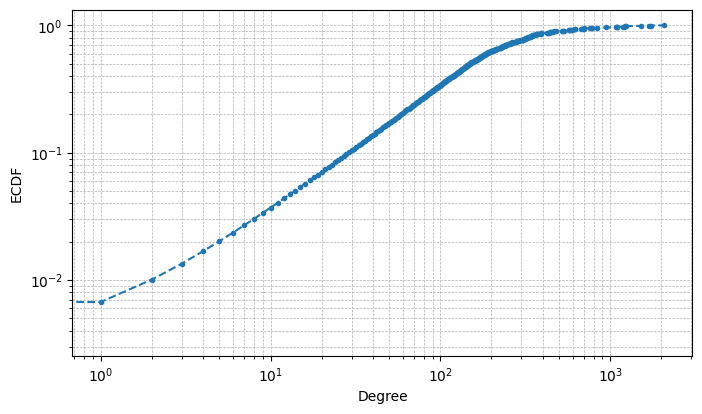

In [63]:
def ECDF(x):
    y = np.arange(1, len(x) + 1) / len(x)
    return y
x = np.unique(G_degreelist)
y = ECDF(x)
fig_cdf_function = plt.figure(figsize=(8,4.5))
axes = fig_cdf_function.gca()
axes.loglog(x,y, linestyle = '--', marker= 'o', ms=3)
axes.set_xlabel('Degree')
axes.set_ylabel('ECDF')
plt.grid(which="both", linestyle="--", linewidth=0.5)

ECCDF of the network shows a **long tail**, typical of **scale-free networks**, where few hubs have a high degree, while the majority has a low degree. This structure is typical of social network, where few users have a lot of connections. 

To better understand the structure, let's compare this distribution with two important models: **random networks** (Erdős-Rényi) and **small-world models** (Watts-Strogatz).

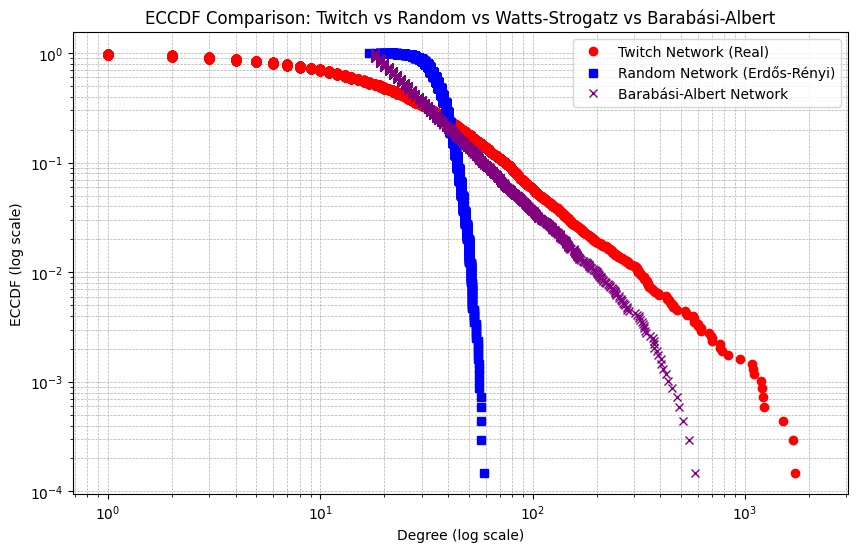

In [53]:
# ECCDF Function
def compute_eccdf(degree_sequence):
    sorted_degrees = np.sort(degree_sequence)
    cumulative = np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees)
    return sorted_degrees, 1 - cumulative  # ECCDF = 1 - CDF

# Degree sequence for the real graph
real_degrees = [d for _, d in G.degree()]

# Generate random graph (Erdős-Rényi)
random_graph = nx.gnm_random_graph(n=G.number_of_nodes(), m=G.number_of_edges())
random_degrees = [d for _, d in random_graph.degree()]

# Compute ECCDFs
real_x, real_eccdf = compute_eccdf(real_degrees)
random_x, random_eccdf = compute_eccdf(random_degrees)

# Genera il grafo Barabási-Albert
ba_graph = nx.barabasi_albert_graph(n=G.number_of_nodes(), m=int(np.mean(real_degrees) // 2))
ba_degrees = [d for _, d in ba_graph.degree()]

# Compute ECCDF for Barabási-Albert
ba_x, ba_eccdf = compute_eccdf(ba_degrees)

# Plot ECCDFs including Barabási-Albert
plt.figure(figsize=(10, 6))
plt.loglog(real_x, real_eccdf, label="Twitch Network (Real)", marker="o", linestyle="none", color="red")
plt.loglog(random_x, random_eccdf, label="Random Network (Erdős-Rényi)", marker="s", linestyle="none", color="blue")
plt.loglog(ba_x, ba_eccdf, label="Barabási-Albert Network", marker="x", linestyle="none", color="purple")

# Customize the plot
plt.xlabel("Degree (log scale)")
plt.ylabel("ECCDF (log scale)")
plt.title("ECCDF Comparison: Twitch vs Random vs Watts-Strogatz vs Barabási-Albert")
plt.legend()
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.show()

- The **Erdős-Rényi model** fails to replicate the heterogeneity of the Twitch network, as it generates networks with a uniform degree distribution. There are no hubs.
- The **Barabási-Albert model** provides the closest approximation to the real network, highlighting the preferential attachment mechanism behind the emergence of hubs.

This comparison confirms that the Twitch network follows a scale-free structure, with the Barabási-Albert model being the most suitable representation of its degree distribution.


---
### **2. Connectivity**


In this section, I analyze the role of hubs in maintaining the connectivity of the network. Hubs are defined as nodes with a degree in the top 5% of the network (95th percentile). Three main points:
1. The number and structure of connected components in the entire network.
2. The connectivity among hubs (subgraph of hubs).
3. The impact of removing hubs on the overall network structure.

In [67]:
# Determina la soglia degli hub (95° percentile)
hub_threshold = np.percentile(G_degreelist, 95)
hubs = {k for k, v in G.degree() if v >= hub_threshold}
print(f"Hub threshold: {hub_threshold}")
print(f"Number of hubs: {len(hubs)}")

Hub threshold: 108.09999999999945
Number of hubs: 340


Nodes with a degree **higher than 108** are classified as hubs.

I found a total of **340 hubs**, which are the top 5% of the most connected nodes. 

In [73]:
# Numero di componenti connesse nella rete completa
connected_components = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print(f"Number of connected components: {len(connected_components)}")
print(f"Size of largest connected component: {connected_components[0]}") 
print(f'Size of each component: {connected_components}')# Giant component

Number of connected components: 78
Size of largest connected component: 6720
Size of each component: [6720, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


The network contains **78** connected components. Checking the dimensione of each of them, I stated that there is one **giant component** with 6720 nodes and all the other components are of size 1 or 2.

In [71]:
# Sottografo degli hub
hub_subgraph = G.subgraph(hubs).copy()

# Numero di componenti connesse tra gli hub
hubs_ccs = len(list(nx.connected_components(hub_subgraph)))
print(f"Number of connected components among hubs: {hubs_ccs}")

# Dimensione della componente connessa principale tra gli hub
hub_components_sizes = [len(c) for c in sorted(nx.connected_components(hub_subgraph), key=len, reverse=True)]
print(f"Size of largest hub component: {hub_components_sizes[0]}")

Number of connected components among hubs: 1
Size of largest hub component: 340


Anylizing the subgraph of hubs reveals that they form a **single connected component**. This means that top streamers in Twitch are strongly interconnected and form a dense network.

In [74]:
# Rimozione degli hub dalla rete
G_no_hubs = G.copy()
G_no_hubs.remove_nodes_from(hubs)

# Numero di componenti connesse dopo la rimozione degli hub
no_hubs_components = [len(c) for c in sorted(nx.connected_components(G_no_hubs), key=len, reverse=True)]
print(f"Number of connected components without hubs: {len(no_hubs_components)}")
print(f"Size of largest component without hubs: {no_hubs_components[0]}") 
print(f'Size of each component: {no_hubs_components}')# Giant component

Number of connected components without hubs: 374
Size of largest component without hubs: 6075
Size of each component: [6075, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Removing the 340 hubs increases the number of connected components from 78 to 374, which might appear as a significant increase. However, this growth is largely meaningless, as the newly disconnected components consist predominantly of isolated nodes or very small clusters of size 1 or 2.

The size of the largest connected component decreases only slightly, from 6,720 to 6,075 nodes, retaining the vast majority of the network. This demonstrates that while hubs play a key role in connecting smaller peripheral components, the network’s core structure remains robust and largely unaffected by their removal.

### Hub Analysis in the Twitch Network

- **Hub Threshold**: Nodes with a degree of **108 or higher** are classified as hubs, representing the top **5% of nodes** in terms of connectivity.
- **Number of Hubs**: A total of **340 hubs** were identified, showcasing the heterogeneous structure of the network, with a small fraction of nodes having significantly higher connectivity than the rest.
- **Connected Component of Hubs**: All hubs belong to a **single connected component**, indicating a highly cohesive core structure within the network. This suggests that hubs play a critical role in maintaining network connectivity and facilitating communication between different regions of the network.

Hubs are likely to act as bridges between communities and contribute to the robustness of the network. Further analysis will investigate their centrality and influence in the Twitch network.